In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
BATCH_SIZE = 64
IMAGE_SIZE = 300
train_path = "../input/dermnet/train"
test_path = "../input/dermnet/test"

In [3]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR,IMAGE_SIZE,BATCH_SIZE):
  train_datagen = ImageDataGenerator(rescale=(1./255),
                                     shear_range=0.2,
                                     zoom_range=0.3,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     brightness_range=[0.2,1.2],
                                     rotation_range=0.2,
                                     horizontal_flip=True)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(IMAGE_SIZE, IMAGE_SIZE))

  test_datagen = ImageDataGenerator(rescale=1./255)

  
  test_generator = test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE))
  
  return train_generator, test_generator

In [4]:
train_generator,test_generator=train_val_generators(train_path, test_path,IMAGE_SIZE,BATCH_SIZE)

Found 15557 images belonging to 23 classes.
Found 4002 images belonging to 23 classes.


(64, 300, 300, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


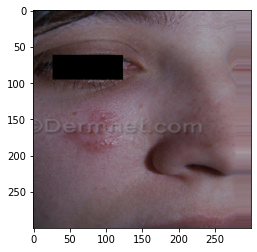

(64, 300, 300, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


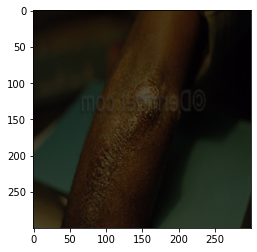

(64, 300, 300, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


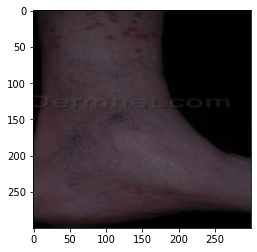

(64, 300, 300, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


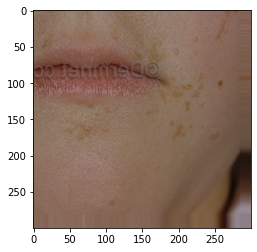

(64, 300, 300, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


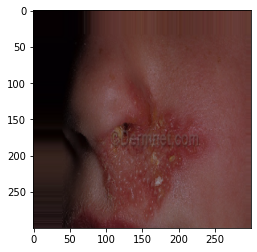

In [5]:
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)  
    print(label[0])
    plt.imshow(img[0])
    plt.show()

In [6]:
class_names = train_generator.class_indices
class_names

{'Acne and Rosacea Photos': 0,
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 1,
 'Atopic Dermatitis Photos': 2,
 'Bullous Disease Photos': 3,
 'Cellulitis Impetigo and other Bacterial Infections': 4,
 'Eczema Photos': 5,
 'Exanthems and Drug Eruptions': 6,
 'Hair Loss Photos Alopecia and other Hair Diseases': 7,
 'Herpes HPV and other STDs Photos': 8,
 'Light Diseases and Disorders of Pigmentation': 9,
 'Lupus and other Connective Tissue diseases': 10,
 'Melanoma Skin Cancer Nevi and Moles': 11,
 'Nail Fungus and other Nail Disease': 12,
 'Poison Ivy Photos and other Contact Dermatitis': 13,
 'Psoriasis pictures Lichen Planus and related diseases': 14,
 'Scabies Lyme Disease and other Infestations and Bites': 15,
 'Seborrheic Keratoses and other Benign Tumors': 16,
 'Systemic Disease': 17,
 'Tinea Ringworm Candidiasis and other Fungal Infections': 18,
 'Urticaria Hives': 19,
 'Vascular Tumors': 20,
 'Vasculitis Photos': 21,
 'Warts Molluscum and other Viral Inf

In [7]:
NUMBER_OF_CLASSES = len(class_names)
print(f'number of classes : {NUMBER_OF_CLASSES}')

number of classes : 23


In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights = 'imagenet')

2022-05-30 02:49:54.233428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 02:49:54.358601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 02:49:54.359568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 02:49:54.361099: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 0s 0us/step


In [9]:
for layer in base_model.layers:
    layer.trainable = True

In [10]:
def output_of_last_layer(pre_trained_model, limit_layer):
  last_desired_layer = pre_trained_model.get_layer(limit_layer)
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [11]:
last_output = output_of_last_layer(base_model,'mixed5')

last layer output shape:  (None, 17, 17, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 17, 17, 768), dtype=tf.float32, name=None), name='mixed5/concat:0', description="created by layer 'mixed5'")


In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(
    optimizer = Adam(learning_rate=0.001), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    min_delta=0.001, 
    mode='min'
)

In [14]:
history = model.fit(
    train_generator, 
    validation_data = test_generator, 
    epochs = 40, 
    callbacks=[custom_early_stopping]
    )

2022-05-30 02:50:01.169076: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-05-30 02:50:05.118310: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 909115392 exceeds 10% of free system memory.
2022-05-30 02:50:05.687352: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 909115392 exceeds 10% of free system memory.
2022-05-30 02:50:06.578074: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 909115392 exceeds 10% of free system memory.
2022-05-30 02:50:07.185119: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 909115392 exceeds 10% of free system memory.
2022-05-30 02:50:09.267985: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


244/244 [==============================] - 638s 3s/step - loss: 18.0086 - accuracy: 0.1499 - val_loss: 234.3785 - val_accuracy: 0.0837
Epoch 2/40
244/244 [==============================] - 500s 2s/step - loss: 6.4669 - accuracy: 0.2039 - val_loss: 8.0818 - val_accuracy: 0.1774
Epoch 3/40
244/244 [==============================] - 502s 2s/step - loss: 6.0996 - accuracy: 0.2186 - val_loss: 7.3691 - val_accuracy: 0.0847
Epoch 4/40
244/244 [==============================] - 501s 2s/step - loss: 5.7719 - accuracy: 0.1723 - val_loss: 9.1131 - val_accuracy: 0.1204
Epoch 5/40
244/244 [==============================] - 508s 2s/step - loss: 5.4902 - accuracy: 0.1944 - val_loss: 14.5903 - val_accuracy: 0.1607
Epoch 6/40
244/244 [==============================] - 512s 2s/step - loss: 5.5017 - accuracy: 0.2316 - val_loss: 10.8469 - val_accuracy: 0.1504
Epoch 7/40
244/244 [==============================] - 520s 2s/step - loss: 4.8109 - accuracy: 0.2417 - val_loss: 4.8461 - val_accuracy: 0.2186
Epoch

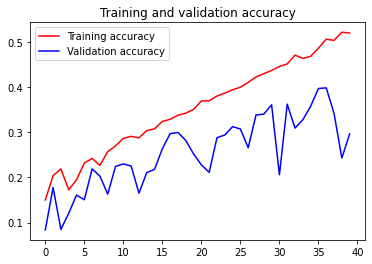

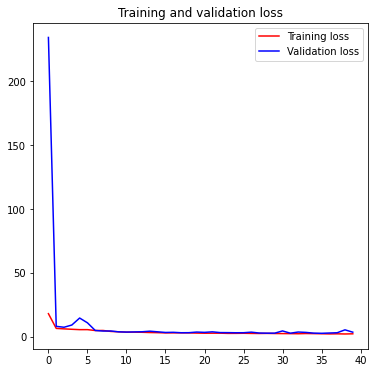

<Figure size 432x432 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure(figsize=(6,6))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure(figsize=(6,6))


plt.show()

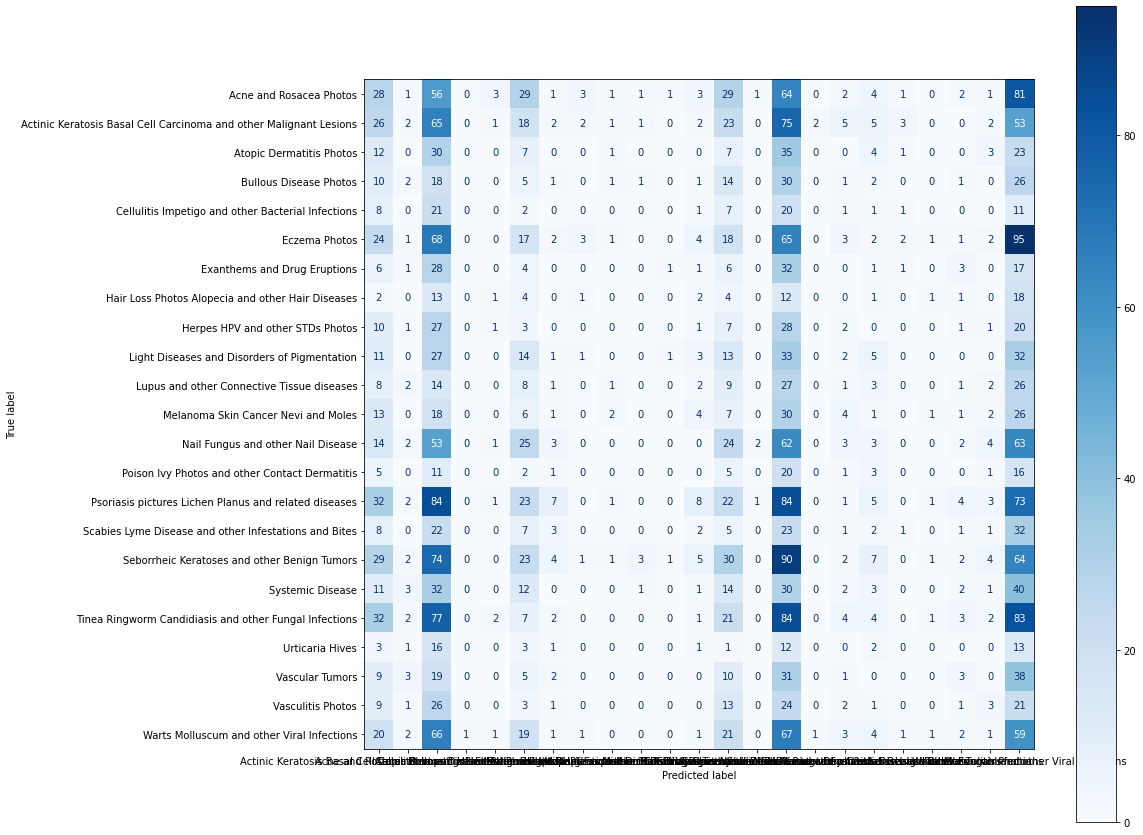

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np

test_true=test_generator.classes
test_pred_raw = model.predict(test_generator)
test_pred = np.argmax(test_pred_raw, axis=1)

cm = confusion_matrix(test_true, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()

In [17]:
# !mkdir -p saved_model
model.save('my_model')

2022-05-30 08:52:57.670426: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-05-30 08:53:11.632131: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 909115392 exceeds 10% of free system memory.
